In [2]:
import matplotlib.pyplot as plt
from pyspark.shell import spark
from pyspark.sql.functions import hour, second, minute, concat, lit
from pyspark.sql.types import (
    StructType, 
    StructField, 
    StringType, 
    TimestampType,
)

from extract_files import ROOT_PATH, export_proper_events

export_proper_events()
schema = StructType([
    StructField("browser", StringType(), True),
    StructField("device", StringType(), True),
    StructField("event_type", StringType(), True),
    StructField("starting_url", StringType(), True),
    StructField("test_case_id", StringType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("uuid", StringType(), True),
    StructField("operating_system", StringType(), True),
])

df = spark.read.json(ROOT_PATH + 'serialized_events.json', schema)
df = df.withColumn(
    'created_at', 
    concat(
        hour(df['timestamp']), 
        lit(':'), 
        minute(df['timestamp']), 
        lit(':'), 
        second(df['timestamp'])
    )
)


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.1
      /_/

Using Python version 3.7.3 (default, Mar 26 2019 21:43:19)
SparkSession available as 'spark'.
{'anonymousId': None, 'channel': 'server', 'context': {'library': {'name': 'analytics-python', 'version': '1.3.0b0'}}, 'event': 'TestCaseFlowTesterDeviceDataGathered', 'integrations': {}, 'messageId': '2e9c5259-8d7c-4a72-9305-de2039590a87', 'originalTimestamp': '2019-03-29T11:08:32.634518+00:00', 'properties': {'browser_data': {'browser_version': '73.0.3683.86', 'window_size': {'height': 1133, 'width': 1200}}, 'device_data': {'device_brand': None, 'device_model': None, 'operating_system': 'Darwin', 'os_language_and_encoding': ['en_US', 'UTF-8'], 'screens_resolutions': {}}, 'metadata': {'browser_name': None, 'result_id': None, 'session_description': None, 'starting_url': 'http://google.com', 'test_case_id': 'f39e8a18bb1bcecb9ae8618f1ffb9b43b9f923

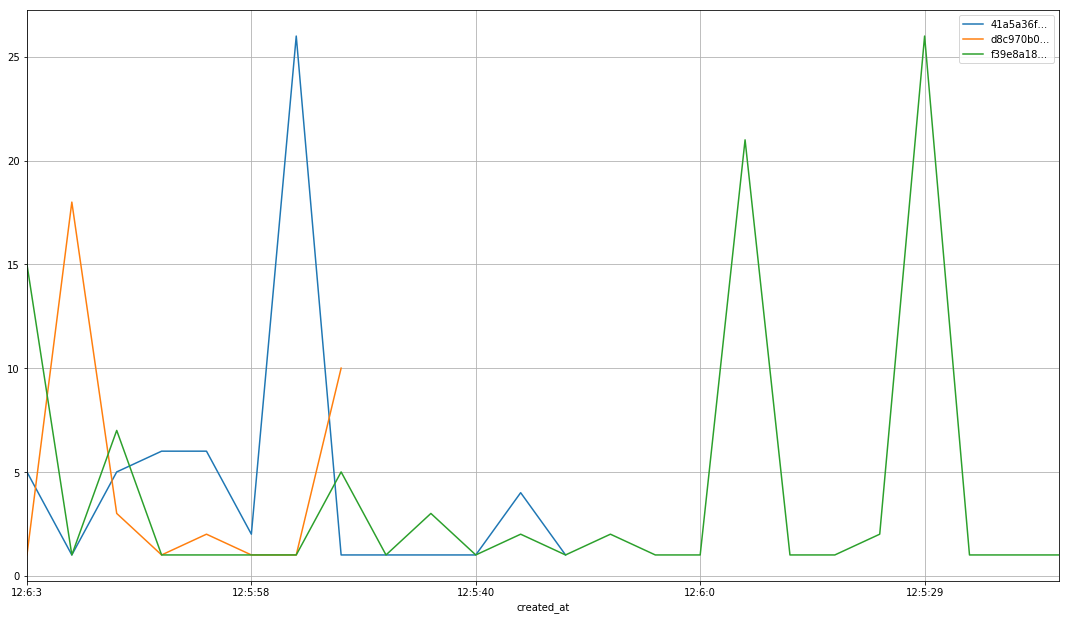

In [3]:
test_case_df = df.groupBy('test_case_id', 'created_at').agg({'uuid': 'count'})
test_case_pdf = test_case_df.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for name, group in test_case_pdf.groupby('test_case_id'):
    group.plot(
        x='created_at', y='count(uuid)', ax=ax, 
        label=name[:8] + '...', grid=True
    )


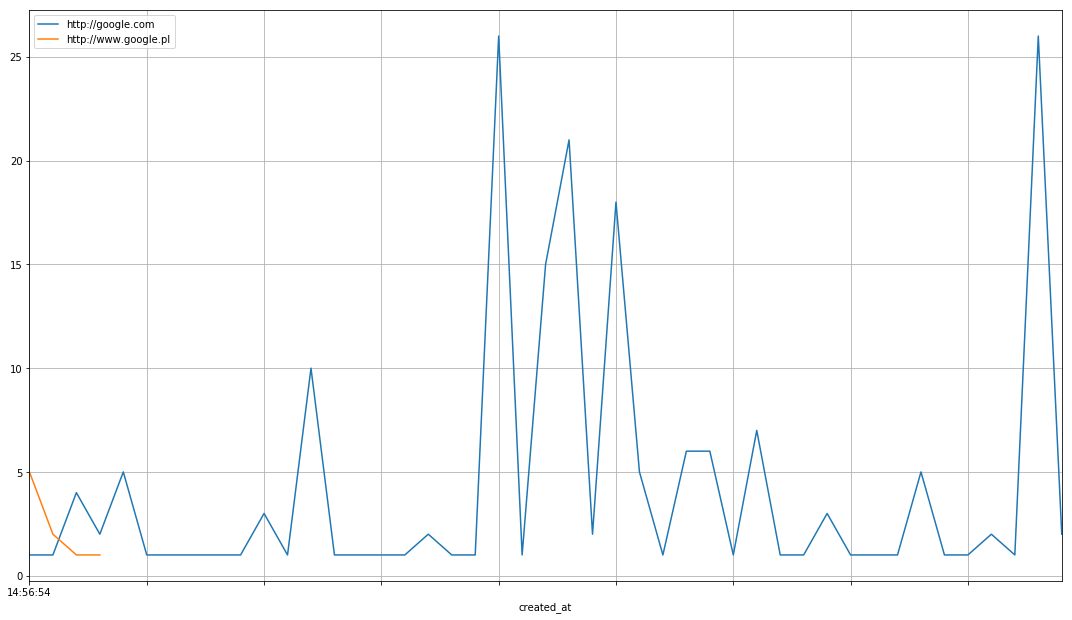

In [4]:
starting_url_df = df.groupBy(
    'starting_url', 'created_at'
).agg({'uuid': 'count'})
starting_url_pdf = starting_url_df.toPandas()
starting_url_pdf.to_parquet('starting_url.parquet.gzip', compression='gzip')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for name, group in starting_url_pdf.groupby('starting_url'):
    group.plot(x='created_at', y='count(uuid)', ax=ax, label=name, grid=True)


In [7]:
test_case_pdf.to_parquet('test_case_id.parquet.gzip', compression='gzip')
starting_url_pdf.to_parquet('starting_url.parquet.gzip', compression='gzip')

